# __Traffic Volume Prediction__
<h2 align="center"><b>Advanced Data Science Capstone Poject by</b></h2>
<h2 align="center"><b>IBM / Coursera</b></h1>
<h2 align=center>Vasilis Kokkinos (September 2019)</h2>

 ## Introduction / Business Problem

USE CASE: Predictive model of traffic volume. It can be used as template for similar situations.

DATA SET: Metro Interstate Traffic Volume Data Set
Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.

Source: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume



### __Attribute Information:__

__holiday:__ Categorical US National holidays plus regional holiday, Minnesota State Fair

__temp:__ Numeric Average temp in kelvin

__rain_1h:__ Numeric Amount in mm of rain that occurred in the hour

__snow_1h:__ Numeric Amount in mm of snow that occurred in the hour

__clouds_all:__ Numeric Percentage of cloud cover

__weather_main:__ Categorical Short textual description of the current weather

__weather_description:__ Categorical Longer textual description of the current weather

__date_time:__ DateTime Hour of the data collected in local CST time

__traffic_volume:__ Numeric Hourly I-94 ATR 301 reported westbound traffic volume

------------------------------------------------------------------------------------------------------

#### __Model Definition__ was performed in the previous step in the notebook __traffic_volume.model_def.py.v01.ipynb__

In that step:
* The initial data frame was split into three parts training, validation and testing. The initial data frame as well as the resulting three, all now have extra normalized columns to be used in deep learning and a vector column to be used in the non deep learning algorithm
* It was determined that the problem was a __non-linear regression__ one
* Initial algorithms were defined, both non-deep learning and deep learning

The resulting data sets and alogorithms were saved and they will be used in the current notebook
    
This notebook, is the __Model Training__ step where the models will be trained and fine-tuned for better peerformance

--------------------------------------------------------------------------------------------

Import necessary packages, initialize Apache Spark session, and add supporting functions

In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import numpy as np

In [2]:
spark = SparkSession.builder.appName('Traffic Volume Prediction').getOrCreate()

# Create an sql context so that we can query data files in sql like syntax
sqlContext = SQLContext(spark)
spark

#### __Read in the training data set__

In [3]:
df_train = spark.read.parquet('traffic_volume_df_train.parquet')

df_train.createOrReplaceTempView('df_train')
df_train.printSchema()

root
 |-- temp: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- clouds_all: integer (nullable = true)
 |-- traffic_volume: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- holidayIndex: integer (nullable = true)
 |-- weatherMainIndex: integer (nullable = true)
 |-- weatherDescIndex: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_norm: vector (nullable = true)
 |-- temp_Norm: double (nullable = true)
 |-- rain_1h_Norm: double (nullable = true)
 |-- snow_1h_Norm: double (nullable = true)
 |-- clouds_all_Norm: double (nullable = true)
 |-- traffic_volume_Norm: double (nullable = true)
 |-- month_Norm: double (nullable = true)
 |-- day_of_week_Norm: double (nullable = true)
 |-- hour_of_day_Norm: double (nullable = true)
 |-- holidayIndex_Norm: double (nullable = true)
 |-- weatherMainIndex_N

## Basic data set checks
For each initial column of the training data frame (and the ones that will be used in this step), there is a corresponding normalized column with the suffix __'_NORM'__

A vector column __'features_norm'__ will be used for the non deep learning algorithm. All other independent features will be used for the deep learning algorithm

In [4]:
df_train.show(1, truncate=False)

+------+-------+-------+----------+--------------+-----+-----------+-----------+------------+----------------+----------------+---------------------------------------------+--------------------------------------------------------------------------------------------------------------------------+---------+------------+------------+---------------+-------------------+----------+----------------+----------------+-----------------+---------------------+---------------------+
|temp  |rain_1h|snow_1h|clouds_all|traffic_volume|month|day_of_week|hour_of_day|holidayIndex|weatherMainIndex|weatherDescIndex|features                                     |features_norm                                                                                                             |temp_Norm|rain_1h_Norm|snow_1h_Norm|clouds_all_Norm|traffic_volume_Norm|month_Norm|day_of_week_Norm|hour_of_day_Norm|holidayIndex_Norm|weatherMainIndex_Norm|weatherDescIndex_Norm|
+------+-------+-------+----------+-------------

In [5]:
print('Number of rows in the training dataframe: {}'.format(df_train.count()))

Number of rows in the training dataframe: 28194


## __NON DEEP LEARNING MODEL TRAINING__

Let's import the pipeline for the model

In [6]:
from pyspark.ml import Pipeline

In [7]:
rfr_model_pl = Pipeline.load('rfr_model_pl.pkl')
rfr_model_pl.getStages()

[RandomForestRegressor_931c203c4b3c]

The pipeline contains only one stage, a __RandomForestRegressor__. Let's extract the model and check its parameters.

In [8]:
randomForestRegressor = rfr_model_pl.getStages()[-1]
model_params = randomForestRegressor.extractParamMap()
for param, value in model_params.items():
    print(param, '=>', value)

RandomForestRegressor_931c203c4b3c__cacheNodeIds => False
RandomForestRegressor_931c203c4b3c__checkpointInterval => 10
RandomForestRegressor_931c203c4b3c__featureSubsetStrategy => auto
RandomForestRegressor_931c203c4b3c__featuresCol => features_norm
RandomForestRegressor_931c203c4b3c__impurity => variance
RandomForestRegressor_931c203c4b3c__labelCol => traffic_volume
RandomForestRegressor_931c203c4b3c__maxBins => 32
RandomForestRegressor_931c203c4b3c__maxDepth => 5
RandomForestRegressor_931c203c4b3c__maxMemoryInMB => 256
RandomForestRegressor_931c203c4b3c__minInfoGain => 0.0
RandomForestRegressor_931c203c4b3c__minInstancesPerNode => 1
RandomForestRegressor_931c203c4b3c__numTrees => 20
RandomForestRegressor_931c203c4b3c__predictionCol => prediction
RandomForestRegressor_931c203c4b3c__seed => 6208668353818747712
RandomForestRegressor_931c203c4b3c__subsamplingRate => 1.0


Let's train the model with the training data set and with its default parameters and also evaluate it against the training data set

As performance measurement, I will use __R-squared (r2)__ so I can get a normalized score

In [9]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator().setMetricName('r2').setPredictionCol("prediction").setLabelCol("traffic_volume")

In [10]:
ndl_model_rfr = randomForestRegressor.fit(df_train)
ndl_prediction_rfr = ndl_model_rfr.transform(df_train)
ndl_score_rfr = evaluator.evaluate(ndl_prediction_rfr)

print('\tScore: ', ndl_score_rfr)

	Score:  0.8513601641933375


#### Following the suggestiong of the instructor __Romeo Kienzler__, let's also try __GBTRegressor__

In [11]:
from pyspark.ml.regression import GBTRegressor

In [12]:
gbtRegressor = GBTRegressor(labelCol='traffic_volume', featuresCol='features_norm', predictionCol='prediction')

ndl_model_gbt = gbtRegressor.fit(df_train)
ndl_prediction_gbt = ndl_model_gbt.transform(df_train)
ndl_score_gbt = evaluator.evaluate(ndl_prediction_gbt)

print('\tScore: ', ndl_score_gbt)

	Score:  0.9426269147471091


#### Indeed it performed much better
Let's check its parameters

In [13]:
model_params = gbtRegressor.extractParamMap()
for param, value in model_params.items():
    print(param, '=>', value)

GBTRegressor_05786ef0b7d6__seed => 6462429939505428196
GBTRegressor_05786ef0b7d6__predictionCol => prediction
GBTRegressor_05786ef0b7d6__labelCol => traffic_volume
GBTRegressor_05786ef0b7d6__featuresCol => features_norm
GBTRegressor_05786ef0b7d6__maxDepth => 5
GBTRegressor_05786ef0b7d6__maxBins => 32
GBTRegressor_05786ef0b7d6__minInstancesPerNode => 1
GBTRegressor_05786ef0b7d6__minInfoGain => 0.0
GBTRegressor_05786ef0b7d6__maxMemoryInMB => 256
GBTRegressor_05786ef0b7d6__cacheNodeIds => False
GBTRegressor_05786ef0b7d6__subsamplingRate => 1.0
GBTRegressor_05786ef0b7d6__checkpointInterval => 10
GBTRegressor_05786ef0b7d6__lossType => squared
GBTRegressor_05786ef0b7d6__maxIter => 20
GBTRegressor_05786ef0b7d6__stepSize => 0.1
GBTRegressor_05786ef0b7d6__impurity => variance
GBTRegressor_05786ef0b7d6__featureSubsetStrategy => all


One comparable parameter is __featureSubsetStrategy__. Let's try training and evaluating the randomForestRegressor with featureSubsetStrategy set to 'all'

In [14]:
randomForestRegressor.set(randomForestRegressor.getParam('featureSubsetStrategy'), 'all')

ndl_model_rfr = randomForestRegressor.fit(df_train)
ndl_prediction_rfr = ndl_model_rfr.transform(df_train)
ndl_score_rfr = evaluator.evaluate(ndl_prediction_rfr)

print('\tScore: ', ndl_score_rfr)

	Score:  0.9141535520423105


The performance of randomForestRegressor did improve, but still, it did not reach the performance of gbtRegressor.

#### So we will use __GBTRegressor__

#### __GRID SEARCH__
#### Using Grid Seach, let's try to improve the performance of the model
We will iterate through values of the parameters __maxDepth__ with values in (5, 10, 15, 20) and __minInfoGain__ with values in (0, 0.3, 0.5)

In [15]:
# Define the hyperparameters lists
maxDepths = [5, 10, 15, 20]
minInfoGains = [0, 0.3, 0.5]

score_max = 0

# Run the Grid Search
for maxDepth in maxDepths:
    gbtRegressor.set(gbtRegressor.getParam('maxDepth'), maxDepth)
    for minInfoGain in minInfoGains:
        gbtRegressor.set(gbtRegressor.getParam('minInfoGain'), minInfoGain)
        score = evaluator.evaluate(gbtRegressor.fit(df_train).transform(df_train))
        print('\tFor maxDepth = {}, minInfoGain = {} => score = {}'.format(maxDepth, minInfoGain, score))
        if score > score_max:
            score_max = score
            maxDepth_max = maxDepth
            minInfoGain_max = minInfoGain

print('Maximum score {} was achieved with maxDepth {} and minInfoGain {}'.format(score_max, maxDepth_max, minInfoGain_max))

	For maxDepth = 5, minInfoGain = 0 => score = 0.9426269147471091
	For maxDepth = 5, minInfoGain = 0.3 => score = 0.9426269147471091
	For maxDepth = 5, minInfoGain = 0.5 => score = 0.9426269147471091
	For maxDepth = 10, minInfoGain = 0 => score = 0.9738647586109566
	For maxDepth = 10, minInfoGain = 0.3 => score = 0.9738647586013968
	For maxDepth = 10, minInfoGain = 0.5 => score = 0.9738647586013968
	For maxDepth = 15, minInfoGain = 0 => score = 0.9940033559532351
	For maxDepth = 15, minInfoGain = 0.3 => score = 0.9943949621579685
	For maxDepth = 15, minInfoGain = 0.5 => score = 0.9943949611595072
	For maxDepth = 20, minInfoGain = 0 => score = 0.9984686737637012
	For maxDepth = 20, minInfoGain = 0.3 => score = 0.9980227792209548
	For maxDepth = 20, minInfoGain = 0.5 => score = 0.9978958468264516
Maximum score 0.9984686737637012 was achieved with maxDepth 20 and minInfoGain 0


So let's just again define the model with __maxDepth 20__ and __minInfoGain 0__ (which is the default)

In [16]:
gbtRegressor = GBTRegressor(labelCol='traffic_volume', featuresCol='features_norm', predictionCol='prediction', maxDepth=20)

Finally let's create a Pipeline with the __GBTRegressor__ model as its only stage and save it in __gbt_model_pl.pkl__

In [17]:
gbt_ndl_model_pl = Pipeline(stages=[gbtRegressor])
gbt_ndl_model_pl.write().overwrite().save('gbt_model_pl.pkl')

## __DEEP LEARNING MODEL TRAINING__

#### We will work with the training data set __df_train__ and use the validation data set __df_val__ for initial validation purposes

Read in the validation data set

In [18]:
df_val = spark.read.parquet('traffic_volume_df_val.parquet')

df_val.createOrReplaceTempView('df_val')
df_val.printSchema()

root
 |-- temp: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- clouds_all: integer (nullable = true)
 |-- traffic_volume: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- holidayIndex: integer (nullable = true)
 |-- weatherMainIndex: integer (nullable = true)
 |-- weatherDescIndex: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_norm: vector (nullable = true)
 |-- temp_Norm: double (nullable = true)
 |-- rain_1h_Norm: double (nullable = true)
 |-- snow_1h_Norm: double (nullable = true)
 |-- clouds_all_Norm: double (nullable = true)
 |-- traffic_volume_Norm: double (nullable = true)
 |-- month_Norm: double (nullable = true)
 |-- day_of_week_Norm: double (nullable = true)
 |-- hour_of_day_Norm: double (nullable = true)
 |-- holidayIndex_Norm: double (nullable = true)
 |-- weatherMainIndex_N

In [19]:
df_val.show(1, truncate=False)

+------+-------+-------+----------+--------------+-----+-----------+-----------+------------+----------------+----------------+---------------------------------------------+--------------------------------------------------------------------------------------------------------------------------+---------+------------+------------+---------------+-------------------+----------+----------------+----------------+-----------------+---------------------+---------------------+
|temp  |rain_1h|snow_1h|clouds_all|traffic_volume|month|day_of_week|hour_of_day|holidayIndex|weatherMainIndex|weatherDescIndex|features                                     |features_norm                                                                                                             |temp_Norm|rain_1h_Norm|snow_1h_Norm|clouds_all_Norm|traffic_volume_Norm|month_Norm|day_of_week_Norm|hour_of_day_Norm|holidayIndex_Norm|weatherMainIndex_Norm|weatherDescIndex_Norm|
+------+-------+-------+----------+-------------

In [20]:
print('Number of rows in the validation dataframe: {}'.format(df_val.count()))

Number of rows in the validation dataframe: 8266


#### We will use the normalized columns from both the training and the validation data frames

Create arrays that correspond to the training and validation data sets

In [21]:
# Create temporary dataframes
X_train = df_train['temp_Norm', 'rain_1h_Norm', 'snow_1h_Norm', 'clouds_all_Norm', 'month_Norm', 'day_of_week_Norm',
                'hour_of_day_Norm', 'holidayIndex_Norm', 'weatherMainIndex_Norm', 'weatherDescIndex_Norm']
y_train = df_train[['traffic_volume_Norm']]
X_val = df_val['temp_Norm', 'rain_1h_Norm', 'snow_1h_Norm', 'clouds_all_Norm', 'month_Norm', 'day_of_week_Norm',
                'hour_of_day_Norm', 'holidayIndex_Norm', 'weatherMainIndex_Norm', 'weatherDescIndex_Norm']
y_val = df_val[['traffic_volume_Norm']]

In [22]:
# Create the corresponding arrays
X_train.createOrReplaceTempView('X_train')
X_train_arr = np.array(spark.sql('select * from X_train').collect())

y_train.createOrReplaceTempView('y_train')
y_train_arr = np.array(spark.sql('select * from y_train').collect())

X_val.createOrReplaceTempView('X_val')
X_val_arr = np.array(spark.sql('select * from X_val').collect())

y_val.createOrReplaceTempView('y_val')
y_val_arr = np.array(spark.sql('select * from y_val').collect())

#### __Keras__ is used as the Deep Learning framework

In [23]:
from keras.models import Sequential
from keras.layers import Dense

from keras.initializers import VarianceScaling

# For the model compilation
from keras.optimizers import Adam, Nadam
from keras import metrics

Using TensorFlow backend.


First of all, let's import the architecture of the neural network

In [24]:
from keras.models import model_from_json
import json

In [25]:
with open('traffic_volume_dl_model.json') as traffic_volume_dl_model_json_file:
    traffic_volume_dl_model_json = json.load(traffic_volume_dl_model_json_file)
model = model_from_json(traffic_volume_dl_model_json)
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 512)               10752     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 64)             

In our initial mdel definition, the optimizer was __Adam__ and the activation on the last layer was __linear__

Now we will run a __Grid Search__ to experiment wih optimizer __Nadam__ and activation __relu__

Let us define a create a function to define, compile and fit the model for different values of optimizers __(Adam, Nadam)__ and activations of the last model of the layer __(linear, relu)__

The kernel initializer will be from __VarianceScaling__

In [26]:
kernel_initializer=VarianceScaling(distribution='uniform')

For each pair of activation and optimizer, the model will be fit for 300 epochs in silent mode so that the output will not fill the notebook.

At the end of each fit operation the model will be evaluated against the training data and the metrics will be displayed and finally the best result will be printed

In [27]:
def test_model(activation, optimizer):

    model = Sequential()
    model.add(Dense(20, input_shape=(10,), kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dense(512, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dense(256, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dense(128, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dense(64, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dense(32, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dense(64, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dense(16, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dense(8, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dense(4, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dense(1, kernel_initializer=kernel_initializer, activation=activation))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae'])

    model.fit(X_train_arr, y_train_arr, validation_data=(X_val_arr, y_val_arr), epochs=300, batch_size=127, verbose=0)

    score = model.evaluate(X_train_arr, y_train_arr)
    print('\t\tEvaluation Mean Squared Error: ', score[1])
    print('\t\tEvaluation Mean Absolute Error: ', score[2])
    return score[1]

#### __Grid Search__

In [28]:
import timeit

In [29]:
score_min = 1

optimizers = ['Adam', 'Nadam']
activations = ['linear', 'relu']

optimizer_min = ''
activation_min = ''

start_time = timeit.default_timer()

for activation in activations:
    print('Activation: ', activation)
    for optimizer in optimizers:
        print('\tOptimizer: ', optimizer)
        if optimizer == 'Adam':
            optim = Adam()
        elif optimizer == 'Nadam':
            optim = Nadam()
        score = test_model(activation, optim)
        if score <= score_min:
            score_min = score
            activation_min = activation
            optimizer_min = optimizer
                                
elapsed = timeit.default_timer() - start_time
print('\nGrid Search elaped time: ', round(elapsed, 3))
print('\n\nFINISHED GRID SEARCH')

Activation:  linear
	Optimizer:  Adam




28194/28194 [==============================] - 1s 41us/step
		Evaluation Mean Squared Error:  0.001726430579097349
		Evaluation Mean Absolute Error:  0.025934657405020965
	Optimizer:  Nadam
28194/28194 [==============================] - 1s 43us/step
		Evaluation Mean Squared Error:  0.0016975082257168492
		Evaluation Mean Absolute Error:  0.02589232442272786
Activation:  relu
	Optimizer:  Adam
28194/28194 [==============================] - 1s 44us/step
		Evaluation Mean Squared Error:  0.0018787946306015133
		Evaluation Mean Absolute Error:  0.026447327834896697
	Optimizer:  Nadam
28194/28194 [==============================] - 1s 46us/step
		Evaluation Mean Squared Error:  0.0020780536961155943
		Evaluation Mean Absolute Error:  0.02882944386128188

Grid Search elaped time:  1856.796


FINISHED GRID SEARCH


In [30]:
print('Best Mean Squared Error: {} with Activation {} and Optimizer {}:'.format(score_min, activation_min, optimizer_min))

Best Mean Squared Error: 0.0016975082257168492 with Activation linear and Optimizer Nadam:


#### Now let's again define our model using the best values for activation and optimizer

In [52]:
del model
optimizer = Nadam()

model = Sequential()
model.add(Dense(20, input_shape=(10,), kernel_initializer=kernel_initializer, activation='relu'))
model.add(Dense(512, kernel_initializer=kernel_initializer, activation='relu'))
model.add(Dense(256, kernel_initializer=kernel_initializer, activation='relu'))
model.add(Dense(128, kernel_initializer=kernel_initializer, activation='relu'))
model.add(Dense(64, kernel_initializer=kernel_initializer, activation='relu'))
model.add(Dense(32, kernel_initializer=kernel_initializer, activation='relu'))
model.add(Dense(64, kernel_initializer=kernel_initializer, activation='relu'))
model.add(Dense(16, kernel_initializer=kernel_initializer, activation='relu'))
model.add(Dense(8, kernel_initializer=kernel_initializer, activation='relu'))
model.add(Dense(4, kernel_initializer=kernel_initializer, activation='relu'))
model.add(Dense(1, kernel_initializer=kernel_initializer, activation='linear'))

model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae'])

And once more, let's fit and evaluate the model against the training data set

In [53]:
history = model.fit(X_train_arr, y_train_arr, validation_data=(X_val_arr, y_val_arr), epochs=300, batch_size=127, verbose=0)

score = model.evaluate(X_train_arr, y_train_arr)
print('\t\tEvaluation Mean Squared Error: {}'.format(score[1]))
print('\t\tEvaluation Mean Absolute Error: {}'.format(score[2]))

28194/28194 [==============================] - 1s 52us/step
		Evaluation Mean Squared Error: 0.001674305948712752
		Evaluation Mean Absolute Error: 0.025758778695021065


In the __Model Evaluation__ step, we will evaluate our model against the validation and test data sets

### Let's now save the full model in .h5

In [55]:
from keras.models import load_model

In [56]:
model.save('dl_full_model.h5')

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

Finally, let's also visualize how loss is decreased with the epochs

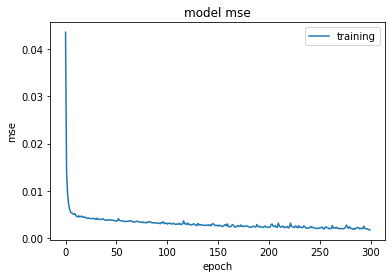

In [65]:
plt.plot(history.history['loss'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper right')

plt.show()

## __Summary__

We now have defined the final non deep learning and deep leerning algorithm for our non-linear regression problem and saved them in:
__gbt_model_pl.pkl__ and __dl_full_model.h5__

The Pipeline and the non-linear model will be taken to the next steps where the algorithms will be evaluated.